In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt 
import numpy as np
import torch
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer

import nmf.mult
import nmf.pgrad
import nmf.nesterov

import nmf_torch.mult
import nmf_torch.pgrad
import nmf_torch.nesterov

import read_data.reading as reading
from theory.represent import rescale_WH

In [53]:
def get_random_lowrank_matrix(m, r, n):
    return np.random.rand(m, r) @ np.random.rand(r, n) 

In [87]:
class HashTfidfBectoriser:
    def __init__(self, n_features):
        self.hashing_vectoriser = HashingVectorizer(n_features=n_features, alternate_sign=False)
        self.tfidf_transformer = TfidfTransformer()
        
    def fit_transform(self, data):
        return self.tfidf_transformer.fit_transform(self.hashing_vectoriser.fit_transform(data))
    
    
def unroll_images(data):
    original_shape  = data.shape
    return data.reshape(original_shape[0], -1), (original_shape[1], original_shape[2])


def roll_images(data, original_image_shape):
    if data.ndim == 1:
        return data.reshape(*original_image_shape)
    else:
        return data.reshape(-1, *original_image_shape)
    
def images_matrix_grid(data, grid_shape):
    imrows = [
        np.hstack([data[i, :, :] 
                   for i in range(grid_shape[1] * a, grid_shape[1] * a + grid_shape[1])])
        for a in range(0, grid_shape[0])
    ]
    return np.vstack(imrows)


def get_time_ratio(errors_0, errors_1):
    # Rartio of times to reach certain cost function value 
    max_log_error = max(np.max(np.log(errors_0[1:, 1])), 
                        np.max(np.log(errors_1[1:, 1])))
    min_log_error = min(np.max(np.log(errors_0[:, 1])), 
                        np.min(np.log(errors_1[:, 1])))
    
    n = 100
    error_space = np.linspace(min_log_error, max_log_error, n)
    time_rates = np.zeros(n) 
    for err_i in range(n):
        try:
            time_0 = errors_0[np.log(errors_0[:, 1]) <= error_space[err_i], 0][0]
            time_1 = errors_1[np.log(errors_1[:, 1]) <= error_space[err_i], 0][0]
            time_rates[err_i] = time_0 / time_1
        except:
            time_rates[err_i] = np.nan
    return np.array([error_space, time_rates]).T

In [19]:
def compare_perofrmance(V, inner_dim, time_limit,
                        W_init, H_init,
                        algo_dict_to_test):
    errors = {}
    for algo_name, algo in algo_dict_to_test.items():
        _, _, errors[algo_name] = algo(V=V,
                                       inner_dim=inner_dim,
                                       record_errors=True,
                                       time_limit=time_limit,
                                       max_steps=np.inf,
                                       epsilon=0,
                                       W_init=W_init.copy(),
                                       H_init=H_init.copy())
    return errors

def plot_perofrmance(errors):
    keys = sorted(errors.keys())
    for name in keys:
        ls = "--" if "torch" in name else "-" 
        plt.plot(errors[name][:, 0], np.log(errors[name][:, 1]), label=name, ls=ls)
    plt.legend()

# Loading data

In [ ]:
reuters_data = reading.read_reuters21578("data/reuters21578")

In [ ]:
print(reuters_data.shape)
reuters_data.toarray().nbytes / 2**30

In [ ]:
indian_pines = reading.read_pines("data/indian_pines/images")
ip_unrolled_site3, ori_shape_site3 = unroll_images(indian_pines["site3_im"])
ip_unrolled_ns_line, ori_shape_ns_line = unroll_images(indian_pines["ns_line_im"])

In [ ]:
faces = reading.read_face_images("data/att_faces/images/")
faces_unrolled, ori_shape_faces = unroll_images(faces)

# Random Data

In [ ]:
shape = (10, 5, 10)
A = get_random_lowrank_matrix(*shape)
W_init = np.random.randn(shape[0], shape[1])
H_init = np.random.randn(shape[1], shape[2])

In [ ]:
W, H, errors_proj_sub = nmf.pgrad.factorise_Fnorm_subproblems(
                              A, inner_dim=5, record_errors=True,
                              n_steps=1000, epsilon=0,
                              W_init=W_init.copy(),
                              H_init=H_init.copy())

W, H, errors_proj_sub_torch = nmf_torch.pgrad.factorise_Fnorm_subproblems(
                                  torch.tensor(A), inner_dim=5, record_errors=True,
                                  n_steps=1000, epsilon=0,
                                  W_init=torch.tensor(W_init.copy()),
                                  H_init=torch.tensor(H_init.copy()))

In [ ]:
f, axs = plt.subplots(2, 1)
axs[0].plot(errors_proj_sub[:, 0], np.log(errors_proj_sub[:, 1]), label="numpy")
axs[0].plot(errors_proj_sub_torch[:, 0], np.log(errors_proj_sub_torch[:, 1]), label="torch")
axs[1].plot(errors_proj_sub_torch[:, 0] / errors_proj_sub[:, 0], label="torch / numpy")
axs[0].legend(); axs[1].legend()

In [ ]:
rate_data = get_time_ratio(errors_proj_sub_torch, errors_proj_sub)
plt.plot(rate_data[:, 0], rate_data[:, 1])
plt.gca().invert_xaxis()

In [ ]:
torch.sqrt(torch.tensor([10]))

# Face Images

In [ ]:
inner_dim_faces = 8
W_init = np.random.randn(faces_unrolled.shape[0], inner_dim_faces)
H_init = np.random.randn(inner_dim_faces, faces_unrolled.shape[1])

W, H, errors_proj_sub = nmf.pgrad.factorise_Fnorm_subproblems(
                                faces_unrolled, 
                                inner_dim=inner_dim_faces,
                                record_errors=True,
                                n_steps=100, epsilon=1e-3,
                                W_init=W_init.copy(),
                                H_init=H_init.copy())

In [ ]:
W, H, errors_proj_sub_torch = nmf_torch.pgrad.factorise_Fnorm_subproblems(
                                            torch.tensor(faces_unrolled, dtype=torch.float64), 
                                            inner_dim=20, 
                                            record_errors=True,
                                            n_steps=100, epsilon=1e-3,
                                            W_init=torch.tensor(W_init.copy()),
                                            H_init=torch.tensor(H_init.copy()))

In [ ]:
W = W.numpy()
H = H.numpy()

In [ ]:
W, H = rescale_WH(W, H)

face_features = roll_images(H, faces_ori_shape)
face_features = images_matrix_grid(face_features, (1, 8))

In [ ]:
plt.imshow(face_features, cmap="gray")

In [ ]:
faces_recovered = roll_images(W @ H, faces_ori_shape)

faces_recovered = images_matrix_grid(faces_recovered, (20, 20))
all_faces = images_matrix_grid(faces, (20, 20))

f, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].imshow(faces_recovered, cmap="gray")
axs[1].imshow(all_faces, cmap="gray")

In [ ]:
f, axs = plt.subplots(2, 1)
axs[0].plot(errors_proj_sub[:, 0], np.log(errors_proj_sub[:, 1]), label="numpy")
axs[0].plot(errors_proj_sub_torch[:, 0], np.log(errors_proj_sub_torch[:, 1]), label="torch")
axs[1].plot(errors_proj_sub_torch[:, 0] / errors_proj_sub[:, 0], label="torch / numpy ")
axs[0].legend(); axs[1].legend()

# Performance evaluation

In [5]:
def torch_algo_wrapper(algo, device="cpu"):
    def algo_w(*args, **kwargs):
        kwargs["V"] =  torch.tensor(kwargs["V"], device=device)
        if "W_init" in kwargs.keys():
            kwargs["W_init"] = torch.tensor(kwargs["W_init"], device=device)
        if "H_init" in kwargs.keys():
            kwargs["H_init"] = torch.tensor(kwargs["H_init"], device=device)
        W, H, errors = algo(*args, **kwargs)
        W = W.numpy()
        H = H.numpy()
        return W, H, errors
    return algo_w

algo_dict_to_test = {
    "mult": nmf.mult.factorise_Fnorm,
    "pgrad": nmf.pgrad.factorise_Fnorm_subproblems,
    "nesterov": nmf.nesterov.factorise_Fnorm,

    "mult_torch": torch_algo_wrapper(nmf_torch.mult.factorise_Fnorm),
    "pgrad_torch": torch_algo_wrapper(nmf_torch.pgrad.factorise_Fnorm_subproblems),
    "nesterov_torch": torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm)
}

In [80]:
np.random.seed(1)

shape = (100, 50, 100)
V = get_random_lowrank_matrix(*shape)
W_init = np.random.rand(shape[0], shape[1])
H_init = np.random.rand(shape[1], shape[2])

<IPython.core.display.Javascript object>


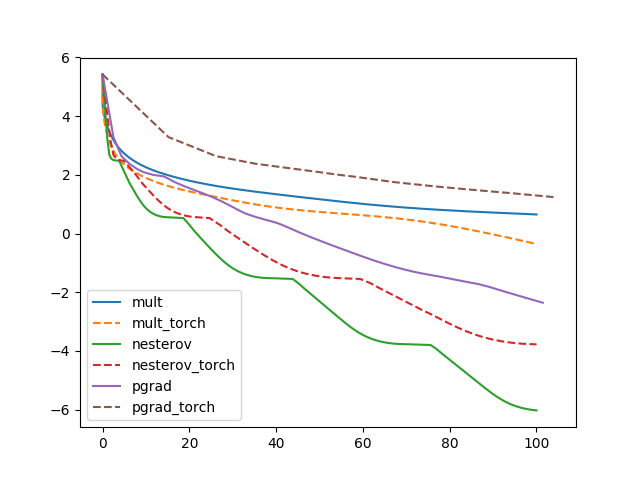

In [82]:
errors = compare_perofrmance(V, 50, time_limit=100,
                             W_init=W_init, H_init=H_init, 
                             algo_dict_to_test=algo_dict_to_test)


<IPython.core.display.Javascript object>


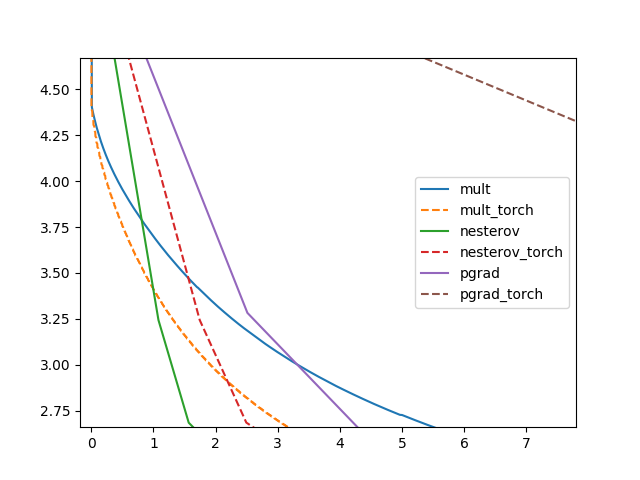

In [91]:
plot_perofrmance(errors)

<IPython.core.display.Javascript object>


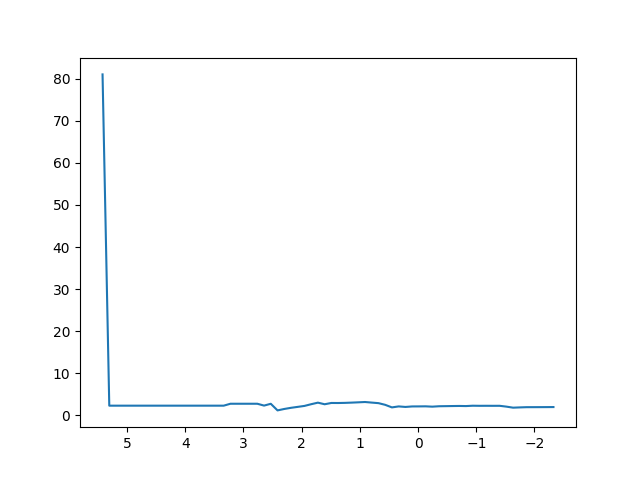

In [90]:
time_ratio = get_time_ratio(errors["pgrad"], errors["nesterov"])
plt.plot(time_ratio[:, 0], time_ratio[:, 1]); plt.gca().invert_xaxis()

In [86]:
time_ratio

array([array([-6.02586952, -5.91023957, -5.79460961, -5.67897966, -5.56334971,
       -5.44771976, -5.33208981, -5.21645986, -5.10082991, -4.98519996,
       -4.86957001, -4.75394006, -4.63831011, -4.52268015, -4.4070502 ,
       -4.29142025, -4.1757903 , -4.06016035, -3.9445304 , -3.82890045,
       -3.7132705 , -3.59764055, -3.4820106 , -3.36638065, -3.2507507 ,
       -3.13512074, -3.01949079, -2.90386084, -2.78823089, -2.67260094,
       -2.55697099, -2.44134104, -2.32571109, -2.21008114, -2.09445119,
       -1.97882124, -1.86319128, -1.74756133, -1.63193138, -1.51630143,
       -1.40067148, -1.28504153, -1.16941158, -1.05378163, -0.93815168,
       -0.82252173, -0.70689178, -0.59126182, -0.47563187, -0.36000192,
       -0.24437197, -0.12874202, -0.01311207,  0.10251788,  0.21814783,
        0.33377778,  0.44940773,  0.56503768,  0.68066764,  0.79629759,
        0.91192754,  1.02755749,  1.14318744,  1.25881739,  1.37444734,
        1.49007729,  1.60570724,  1.72133719,  1.83696714